In [1]:
!date

Tue Jul 27 21:34:46 PDT 2021


# Class DE isoform hidden by gene

In [2]:
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import scanpy as sc
from scipy.stats import ks_2samp, ttest_ind
import ast
from scipy.sparse import csr_matrix
import warnings
warnings.filterwarnings('ignore')


import sys
sys.path.append('../../../BYVSTZP_2020/dexpress')
from dexpress import dexpress, utils, plot

#sys.path.append('../../../BYVSTZP_2020/trackfig')
#from trackfig.utils import get_notebook_name
#from trackfig.trackfig import trackfig 

#TRACKFIG = "../../../BYVSTZP_2020/trackfig.txt"
#NB = get_notebook_name()

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

/home/nmarkari/.local/lib/python3.6/site-packages/numba/core/errors.py:154: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [3]:
subclass_cmap = pd.read_csv('../metadata_files/CTX_Hip_anno_SSv4.csv', index_col='subclass_label',usecols=['subclass_label','subclass_color'])
subclass_cmap = subclass_cmap.drop_duplicates()
subclass_cmap = subclass_cmap.subclass_color.apply(lambda x: mcolors.to_rgb(x) )
subclass_cmap = subclass_cmap.to_dict()

In [4]:
cluster_cmap = {
"Astro": (0.38823529411764707, 0.4745098039215686,  0.2235294117647059 ),  # 637939,
"Endo" : (0.5490196078431373,  0.6352941176470588,  0.3215686274509804 ),  # 8ca252,
"SMC"  : (0.7098039215686275,  0.8117647058823529,  0.4196078431372549 ),  # b5cf6b,
"VLMC" : (0.807843137254902,   0.8588235294117647,  0.611764705882353  ),  # cedb9c,
"Low Quality" : (0,0,0),
"L2/3 IT" : (0.9921568627450981,  0.6823529411764706,  0.4196078431372549  ),  # fdae6b
"L5 PT" : (0.9921568627450981,  0.8156862745098039,  0.6352941176470588  ),  # fdd0a2
"L5 IT" : (0.5176470588235295,  0.23529411764705882, 0.2235294117647059 ),  # 843c39
"L5/6 NP": "#D43F3A",
"L6 CT" : (0.8392156862745098,  0.3803921568627451,  0.4196078431372549 ),  # d6616b
"L6 IT" : (0.9058823529411765,  0.5882352941176471,  0.611764705882353  ),  # e7969c
"L6b" : (1.0,                 0.4980392156862745,  0.054901960784313725),  # ff7f0e
"L6 IT Car3" : (1.0,                 0.7333333333333333,  0.47058823529411764 ),  # ffbb78
"Lamp5" : (0.19215686274509805, 0.5098039215686274,  0.7411764705882353  ),  # 3182bd # blues
"Sncg" : (0.4196078431372549,  0.6823529411764706,  0.8392156862745098  ),  # 6baed6
"Vip" : (0.6196078431372549,  0.792156862745098,   0.8823529411764706  ),  # 9ecae1
"Sst" : (0.7764705882352941,  0.8588235294117647,  0.9372549019607843  ),  # c6dbef
"Pvalb":(0.7372549019607844,  0.7411764705882353,  0.8627450980392157  ),  # bcbddc
}

In [5]:
gene = anndata.read_h5ad("../../data/notebook/revision/gene.h5ad")
struct_dict = {
    "ACA": "CTX",
    "AI": "CTX",
    "ALM": "CTX",
    "AUD": "CTX",
    "ENT": "HPF",
    "ENTl": "HPF",
    "ENTm": "HPF",
    "GU-VISC-AIp": "CTX",
    "HIP": "HPF",
    "MOp": "CTX",
    "MOs-FRP": "CTX",
    "ORB": "CTX",
    "PAR-POST-PRE": "HPF",
    "PAR-POST-PRE-SUB-ProS": "HPF",
    "PL-ILA": "CTX",
    "PL-ILA-ORB": "CTX",
    "PTLp": "CTX", 
    "RSP": "CTX",
    "RSPv": "CTX",
    "SSp": "CTX",
    "SSs": "CTX",
    "SSs-GU-VISC-AIp": "CTX",
    "SUB-ProS": "HPF",
    "TEa-PERI-ECT": "CTX",
    "VIS": "CTX",
    "VISpl-VISpor": "CTX",
    "VISl-VISal-VISli": "CTX",
    "VISam-VISpm": "CTX",
    "VISl": "CTX",
    "VISm": "CTX",
    "VISp": "CTX",
}
gene.obs['struct_label']=gene.obs["region_label"].map(struct_dict)
gene.obs.struct_label.value_counts()

HPF    10905
CTX     7270
Name: struct_label, dtype: int64

In [6]:
isoform = anndata.read_h5ad("../../data/notebook/revision/isoform.h5ad")
isoform.obs['struct_label']=isoform.obs["region_label"].map(struct_dict)

In [7]:
isoform = isoform[:,isoform.var.sort_values("gene_id").index]
gene = gene[:,gene.var.sort_values("gene_id").index]

In [8]:
isoform = isoform[isoform.obs.eval("subclass_label != 'L5 IT'").values]
gene = gene[gene.obs.eval("subclass_label != 'L5 IT'").values]

In [9]:
print(isoform.shape)
print(gene.shape)

(18175, 81527)
(18175, 26154)


In [10]:
mask = np.logical_or(gene.obs.class_label == "GABAergic", gene.obs.class_label == "GABAergic")
m_gene = gene[mask]
m_gene.obs.subclass_label.value_counts()

Lamp5        1424
Vip          1352
Sst          1213
Sncg          720
Pvalb         619
Meis2          65
Sst Chodl      35
Name: subclass_label, dtype: int64

In [13]:
structs = gene.obs.struct_label.unique()
subclasses = gene.obs.subclass_label.unique()
breakdown = pd.DataFrame(index=subclasses, columns=structs)
for struct in structs:
    m = gene.obs.struct_label == struct
    r = gene.obs[m]
    d = r.subclass_label.value_counts()
    d = d.to_dict()
    breakdown[struct] = breakdown.index.map(d)
c = 2 #minimum number of columns that must satisfy criteria
n = 50 #minimum number of cells
b = breakdown.applymap(lambda x: x >=n)
for struct in structs:
    b[struct] = b[struct].map({True:1,False:0})
m2 = b.sum(axis=1) >= c
f_breakdown =breakdown[m2]
f_breakdown

,HPF,CTX
L6b CTX,51,77
Astro,59,73
Lamp5,1019,405
Sncg,544,176
Sst,687,526
Vip,725,627
Pvalb,318,301
L5 IT TPE-ENT,130,130
L2/3 IT PPP,91,400


In [14]:
def gene_dexpress(c_gene):
    mat           = c_gene.layers["log1p"].todense()
    components    = c_gene.obs.cell_id.values
    features      = c_gene.var.gene_name.values
    assignments   = c_gene.obs.struct_label.values

    unique = np.unique(assignments)
    nan_cutoff = 0.9 # of elements in cluster
    corr_method = "bonferroni"


    p_raw, stat, es, nfeat = dexpress.dexpress(mat, components, features, assignments, nan_cutoff=nan_cutoff)
    p_raw = p_raw/2
    p_corr = utils.correct_pval(p_raw, nfeat, corr_method)

    s = stat

    markers_gene = dexpress.make_table(assignments, features, p_raw, p_corr, es)

    # convert the 0 pvalues to the smallest possible float
    markers_gene["p_corr"][markers_gene.eval("p_corr == 0").values] = sys.float_info.min
    markers_gene = markers_gene.query("es > 0")
    return markers_gene

In [15]:
def isoform_dexpress(c_isoform):
    mat         = c_isoform.layers["log1p"].todense() # expects dense matrix
    components  = c_isoform.obs.cell_id.values
    features    = c_isoform.var.transcript_name.values
    assignments = c_isoform.obs.struct_label.values

    unique = np.unique(assignments)
    nan_cutoff = 0.9 # of elements in cluster
    corr_method = "bonferroni"


    p_raw, stat, es, nfeat = dexpress.dexpress(mat, components, features, assignments, nan_cutoff=nan_cutoff)
    p_raw = p_raw/2
    p_corr = dexpress.correct_pval(p_raw, nfeat, corr_method)

    s = stat

    markers_isoform = dexpress.make_table(assignments, features, p_raw, p_corr, es)

    # convert the 0 pvalues to the smallest possible float
    markers_isoform["p_corr"][markers_isoform.eval("p_corr == 0").values] = sys.float_info.min
    markers_isoform = markers_isoform.query("es > 0")
    return markers_isoform

In [16]:
f_breakdown.index

CategoricalIndex(['L6b CTX', 'Astro', 'Lamp5', 'Sncg', 'Sst', 'Vip', 'Pvalb',
                  'L5 IT TPE-ENT', 'L2/3 IT PPP'],
                 categories=['CA1-ProS', 'DG', 'CA3', 'IG-FC', 'L2/3 IT RHP', 'NP SUB', 'SUB-ProS', 'L6 CT CTX', ...], ordered=False, dtype='category')

In [17]:
markers_gene = pd.DataFrame(columns=['index','name','p_raw','p_corr','es','index_name','subclass'])
markers_isoform = pd.DataFrame(columns=['index','name','p_raw','p_corr','es','index_name','subclass'])
for subclass in f_breakdown.index:
    #only want gabaergic
    mask = np.logical_and(gene.obs.subclass_label==subclass ,np.logical_or(gene.obs.class_label == "GABAergic", gene.obs.class_label == "GABAergic"))

    c_gene = gene[mask]
    c_isoform = isoform[mask]
    temp_gene = gene_dexpress(c_gene)
    temp_gene['subclass'] = subclass
    markers_gene = pd.concat([markers_gene,temp_gene])
    temp_isoform = isoform_dexpress(c_isoform)
    temp_isoform['subclass'] = subclass
    markers_isoform = pd.concat([markers_isoform,temp_isoform])
    

27-Jul-21 21:39:15 - 1 of 2 assignments: CTX
27-Jul-21 21:39:15 - 2 of 2 assignments: HPF
27-Jul-21 21:39:18 - 1 of 2 assignments: CTX
27-Jul-21 21:39:19 - 2 of 2 assignments: HPF
27-Jul-21 21:39:21 - 1 of 2 assignments: CTX
27-Jul-21 21:39:21 - 2 of 2 assignments: HPF
27-Jul-21 21:39:22 - 1 of 2 assignments: CTX
27-Jul-21 21:39:22 - 2 of 2 assignments: HPF
27-Jul-21 21:39:23 - 1 of 2 assignments: CTX
27-Jul-21 21:39:23 - 2 of 2 assignments: HPF
27-Jul-21 21:39:24 - 1 of 2 assignments: CTX
27-Jul-21 21:39:25 - 2 of 2 assignments: HPF
27-Jul-21 21:39:26 - 1 of 2 assignments: CTX
27-Jul-21 21:39:26 - 2 of 2 assignments: HPF
27-Jul-21 21:39:27 - 1 of 2 assignments: CTX
27-Jul-21 21:39:28 - 2 of 2 assignments: HPF
27-Jul-21 21:39:29 - 1 of 2 assignments: CTX
27-Jul-21 21:39:29 - 2 of 2 assignments: HPF
27-Jul-21 21:39:30 - 1 of 2 assignments: CTX
27-Jul-21 21:39:30 - 2 of 2 assignments: HPF


In [18]:
#mask = np.logical_and(gene.obs.subclass_label == 'Vip', np.logical_or(gene.obs.class_label == "Glutamatergic", gene.obs.class_label == "GABAergic"))
#mask = (gene.obs.subclass_label == 'Vip')

#c_gene = gene[mask]
#c_isoform = isoform[mask]
#markers_gene= gene_dexpress(c_gene)
#markers_isoform = isoform_dexpress(c_isoform)

# Want to make a mask to return the isoforms for which the isoform is differential but the gene is not

In [19]:
alpha =0.01/len(f_breakdown.index) #second bonferroni correction for multiple subclasses being tested
fc = 2

relevant_genes = markers_gene.p_corr < alpha

markers_gene["index_name"] = markers_gene["index"] + "_" + markers_gene.name.apply(lambda x: "".join(x.split("_")[:-1])) + "_"+ markers_gene["subclass"]
markers_isoform["index_name"] = markers_isoform["index"] + "_" + markers_isoform.name.apply(lambda x: "-".join(x.split("-")[:-1])) + "_"+ markers_isoform["subclass"]

setdiff = np.setdiff1d(markers_isoform["index_name"].values, markers_gene[relevant_genes]["index_name"].values)

In [20]:
markers_isoform = markers_isoform[markers_isoform["index_name"].isin(setdiff)].sort_values(["es", "p_corr"])

markers_isoform = markers_isoform.query(f"p_corr < {alpha}")
markers_isoform.sort_values("es")[::-1][:20]

,index,name,p_raw,p_corr,es,index_name,subclass
81230,CTX,7SK.188-201_ENSMUST00020183253.1,9.66389e-15,2.36475e-11,1.2146,CTX_7SK.188_Pvalb,Pvalb
130938,HPF,Ttc3-224_ENSMUST00000152117.8,5.21426e-10,1.86514e-06,1.02499,HPF_Ttc3_Sncg,Sncg
128958,HPF,Cntnap2-201_ENSMUST00000060839.8,5.8989e-08,0.000211004,0.907121,HPF_Cntnap2_Sncg,Sncg
128607,HPF,Adk-201_ENSMUST00000045376.11,3.6931e-09,1.32102e-05,0.90705,HPF_Adk_Sncg,Sncg
138306,HPF,Immt-201_ENSMUST00000064062.13,1.18021e-08,4.22161e-05,0.893386,HPF_Immt_Sncg,Sncg
47428,CTX,Cntnap2-206_ENSMUST00000207647.2,1.14669e-11,3.03644e-08,0.882112,CTX_Cntnap2_Sncg,Sncg
98087,HPF,Atp5j-202_ENSMUST00000114191.8,4.57909e-08,0.000163794,0.871985,HPF_Atp5j_Sncg,Sncg
96125,HPF,Zfr-203_ENSMUST00000128475.9,1.01706e-07,0.000363802,0.866946,HPF_Zfr_Sncg,Sncg
107508,HPF,Napb-201_ENSMUST00000028926.13,1.78525e-07,0.000638583,0.85413,HPF_Napb_Sncg,Sncg
81230,CTX,7SK.188-201_ENSMUST00020183253.1,3.98761e-14,1.11374e-10,0.830561,CTX_7SK.188_Sst,Sst


In [21]:
markers_gene[markers_gene.name.str.contains("Cntnap2")]
#markers_gene[markers_gene.name.str.contains("Kifap")]

,index,name,p_raw,p_corr,es,index_name,subclass
9431,CTX,Cntnap2_ENSMUSG00000039419.18,1.09152e-07,0.000276809,0.241364,CTX_Cntnap2_Lamp5,Lamp5
9431,CTX,Cntnap2_ENSMUSG00000039419.18,0.483263,1,0.00311704,CTX_Cntnap2_Sncg,Sncg
9431,CTX,Cntnap2_ENSMUSG00000039419.18,0.0653158,1,0.109234,CTX_Cntnap2_Sst,Sst
9431,CTX,Cntnap2_ENSMUSG00000039419.18,0.191617,1,0.0640821,CTX_Cntnap2_Vip,Vip
35585,HPF,Cntnap2_ENSMUSG00000039419.18,0.403788,1,0.0174587,HPF_Cntnap2_Pvalb,Pvalb


In [22]:
isoform.var.transcript_name[isoform.var.transcript_name.str.contains("Cntnap2")]

Cntnap2-203_ENSMUST00000150737.2    Cntnap2-203_ENSMUST00000150737.2
Cntnap2-204_ENSMUST00000196561.2    Cntnap2-204_ENSMUST00000196561.2
Cntnap2-206_ENSMUST00000207647.2    Cntnap2-206_ENSMUST00000207647.2
Cntnap2-205_ENSMUST00000199100.5    Cntnap2-205_ENSMUST00000199100.5
Cntnap2-202_ENSMUST00000114641.8    Cntnap2-202_ENSMUST00000114641.8
Cntnap2-201_ENSMUST00000060839.8    Cntnap2-201_ENSMUST00000060839.8
Name: transcript_name, dtype: object

In [23]:
isoform

View of AnnData object with n_obs × n_vars = 18175 × 81527
    obs: 'cell_id', 'cluster_id', 'cluster_label', 'subclass_id', 'subclass_label', 'region_label', 'class_label', 'cluster_color', 'class_id', 'cell_counts', 'leiden', 'louvain', 'struct_label'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'length', 'gene_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'louvain', 'neighbors'
    obsm: 'X_nca', 'X_nca_tsne', 'X_pca', 'X_pca_tsne'
    layers: 'log1p', 'norm', 'raw', 'scaled'
    obsp: 'connectivities', 'distances'

In [24]:
#specific_cluster = "Glutamatergic"
#specific_gene = "Kifap3_ENSMUSG00000026585.14"
#specific_isoform = "Kifap3-202_ENSMUST00000077642.12"

#specific_cluster = "ENTl"
specific_cluster = "HPF"
specific_gene = "Cntnap2_ENSMUSG00000039419.18"
specific_isoform = "Cntnap2-201_ENSMUST00000060839.8"
specific_subclass = 'Sncg'

In [25]:
def violinplot(data, ax, **kwd): 
    xticklabels = kwd.get("xticklabels", [])
    xticks = kwd.get("xticks", [])
    selected = kwd.get("selected", None)
    color = kwd.get("color", "grey")
    
    if  len(xticks)==0: xticks = np.arange(len(data))+1;
    if  len(xticklabels)==0: xticklabels = np.arange(len(data))+1;
    assert(len(xticks) == len(xticklabels))
        
    violins = ax.violinplot(data, positions=xticks, showmeans=False, showmedians=False, showextrema=False)
    
    for vidx, v in enumerate(violins['bodies']):
        v.set_facecolor(color)
        v.set_edgecolor('black')
        v.set_alpha(1)
        if selected == vidx:
            v.set_facecolor("#D43F3A")

            
    
    for didx, d in enumerate(data):
        x = xticks[didx]
        xx = np.random.normal(x, 0.04, size=len(d))
        
        # actual points
        ax.scatter(xx, d, s = 5, color="white", edgecolor="black", linewidth=1)
        
        # mean and error bars
        mean = np.mean(d)
        stdev = np.sqrt(np.var(d))
        ax.scatter(x, mean, color="lightgrey", edgecolor="black", linewidth=1, zorder=10)    
        ax.vlines(x, mean - stdev, mean+stdev, color='lightgrey', linestyle='-', lw=2, zorder=9)
        
    ax.set(**{"xticks": xticks, "xticklabels":xticklabels})
    
    return ax


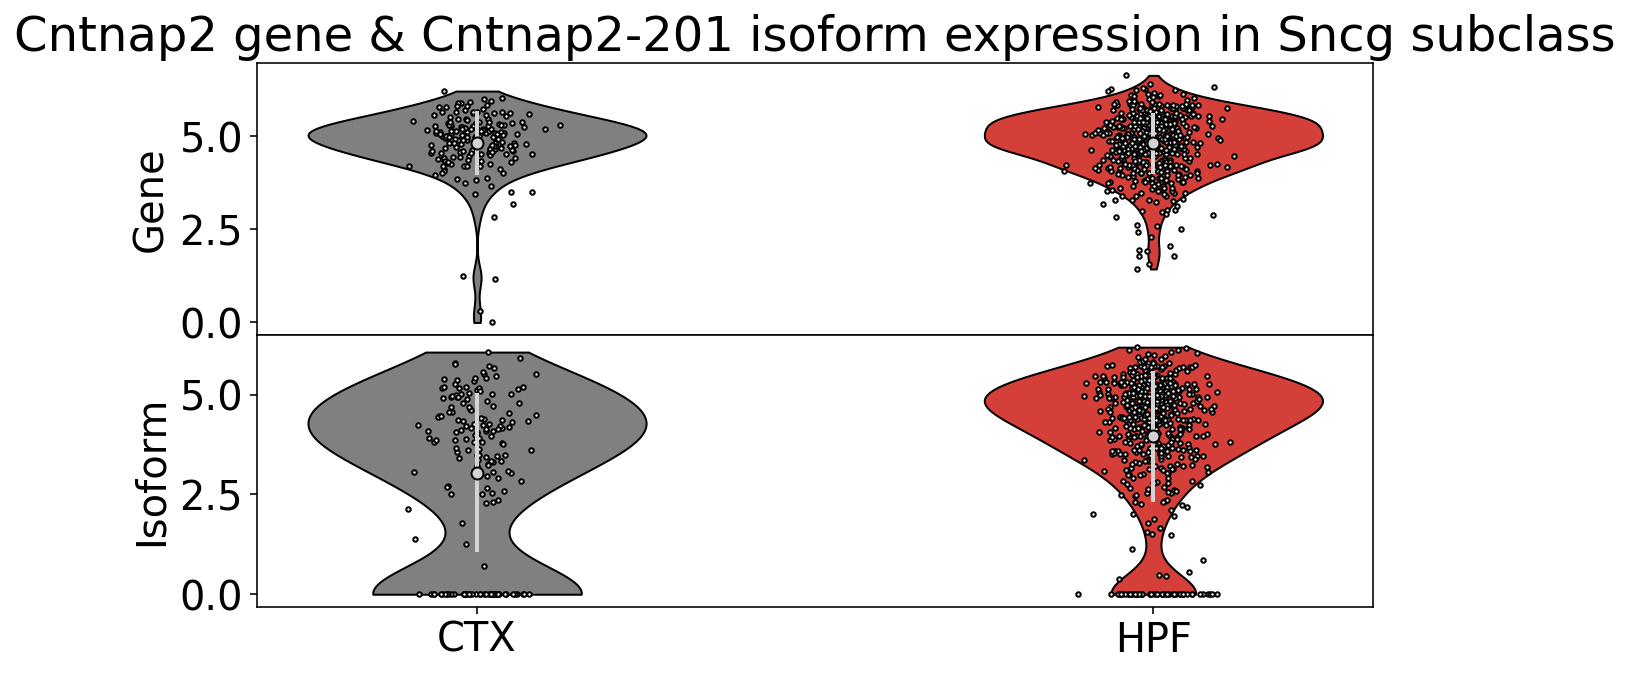

In [26]:
fig, ax = plt.subplots(figsize=(10,5), nrows=2, sharex=True)
fig.subplots_adjust(hspace=0, wspace=0)

mask = np.logical_and(gene.obs.subclass_label == specific_subclass, np.logical_or(gene.obs.class_label == "Glutamatergic", gene.obs.class_label == "GABAergic"))
c_gene = gene[mask]
c_isoform = isoform[mask]
# Declare
unique = np.unique(c_gene.obs.struct_label)
unique = np.delete(unique, np.where(unique=="Low Quality"))
unique = np.delete(unique, np.where(unique=="Non-Neuronal"))
labels = unique
lidx = np.arange(1, len(labels)+1)  # the label locations
midx = np.where(unique==specific_cluster)[0][0]

## Plot
# Gene
x = []
for c in unique:
    x.append(np.asarray(c_gene[c_gene.obs.struct_label==c][:,c_gene.var.gene_name==specific_gene].layers["log1p"].todense()).reshape(-1).tolist())

violinplot(x, ax[0], selected=midx)

# Isoform
x = []
for c in unique:
    x.append(np.asarray(c_isoform[c_isoform.obs.struct_label==c][:,c_isoform.var.transcript_name==specific_isoform].layers["log1p"].todense()).reshape(-1).tolist())

violinplot(x, ax[1], selected=midx, xticks=lidx, xticklabels=labels)
## Style
ax[0].set(**{
    "title":"{} gene & {} isoform expression in {} subclass".format(specific_gene.split("_")[0], specific_isoform.split("_")[0],specific_subclass),
    "ylabel":"Gene",
})

#need to figure out what ax[0] and ax[1] are
ymin, ymax = ax[1].get_ylim()
ax[1].set(**{
    "ylabel":"Isoform",
    "ylim": (ymin, ymax),
})

plt.savefig("../../figures/struct_subclass_DE_violin_all.png", bbox_inches='tight',dpi=300)
plt.show()

# gene.obs

In [27]:
#c = np.asarray(isoform[:, isoform.var.transcript_name==specific_isoform].layers["log1p"].todense()).reshape(-1)
isoform[:, isoform.var.transcript_name==specific_isoform]

View of AnnData object with n_obs × n_vars = 18175 × 1
    obs: 'cell_id', 'cluster_id', 'cluster_label', 'subclass_id', 'subclass_label', 'region_label', 'class_label', 'cluster_color', 'class_id', 'cell_counts', 'leiden', 'louvain', 'struct_label'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'length', 'gene_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'louvain', 'neighbors'
    obsm: 'X_nca', 'X_nca_tsne', 'X_pca', 'X_pca_tsne'
    layers: 'log1p', 'norm', 'raw', 'scaled'
    obsp: 'connectivities', 'distances'

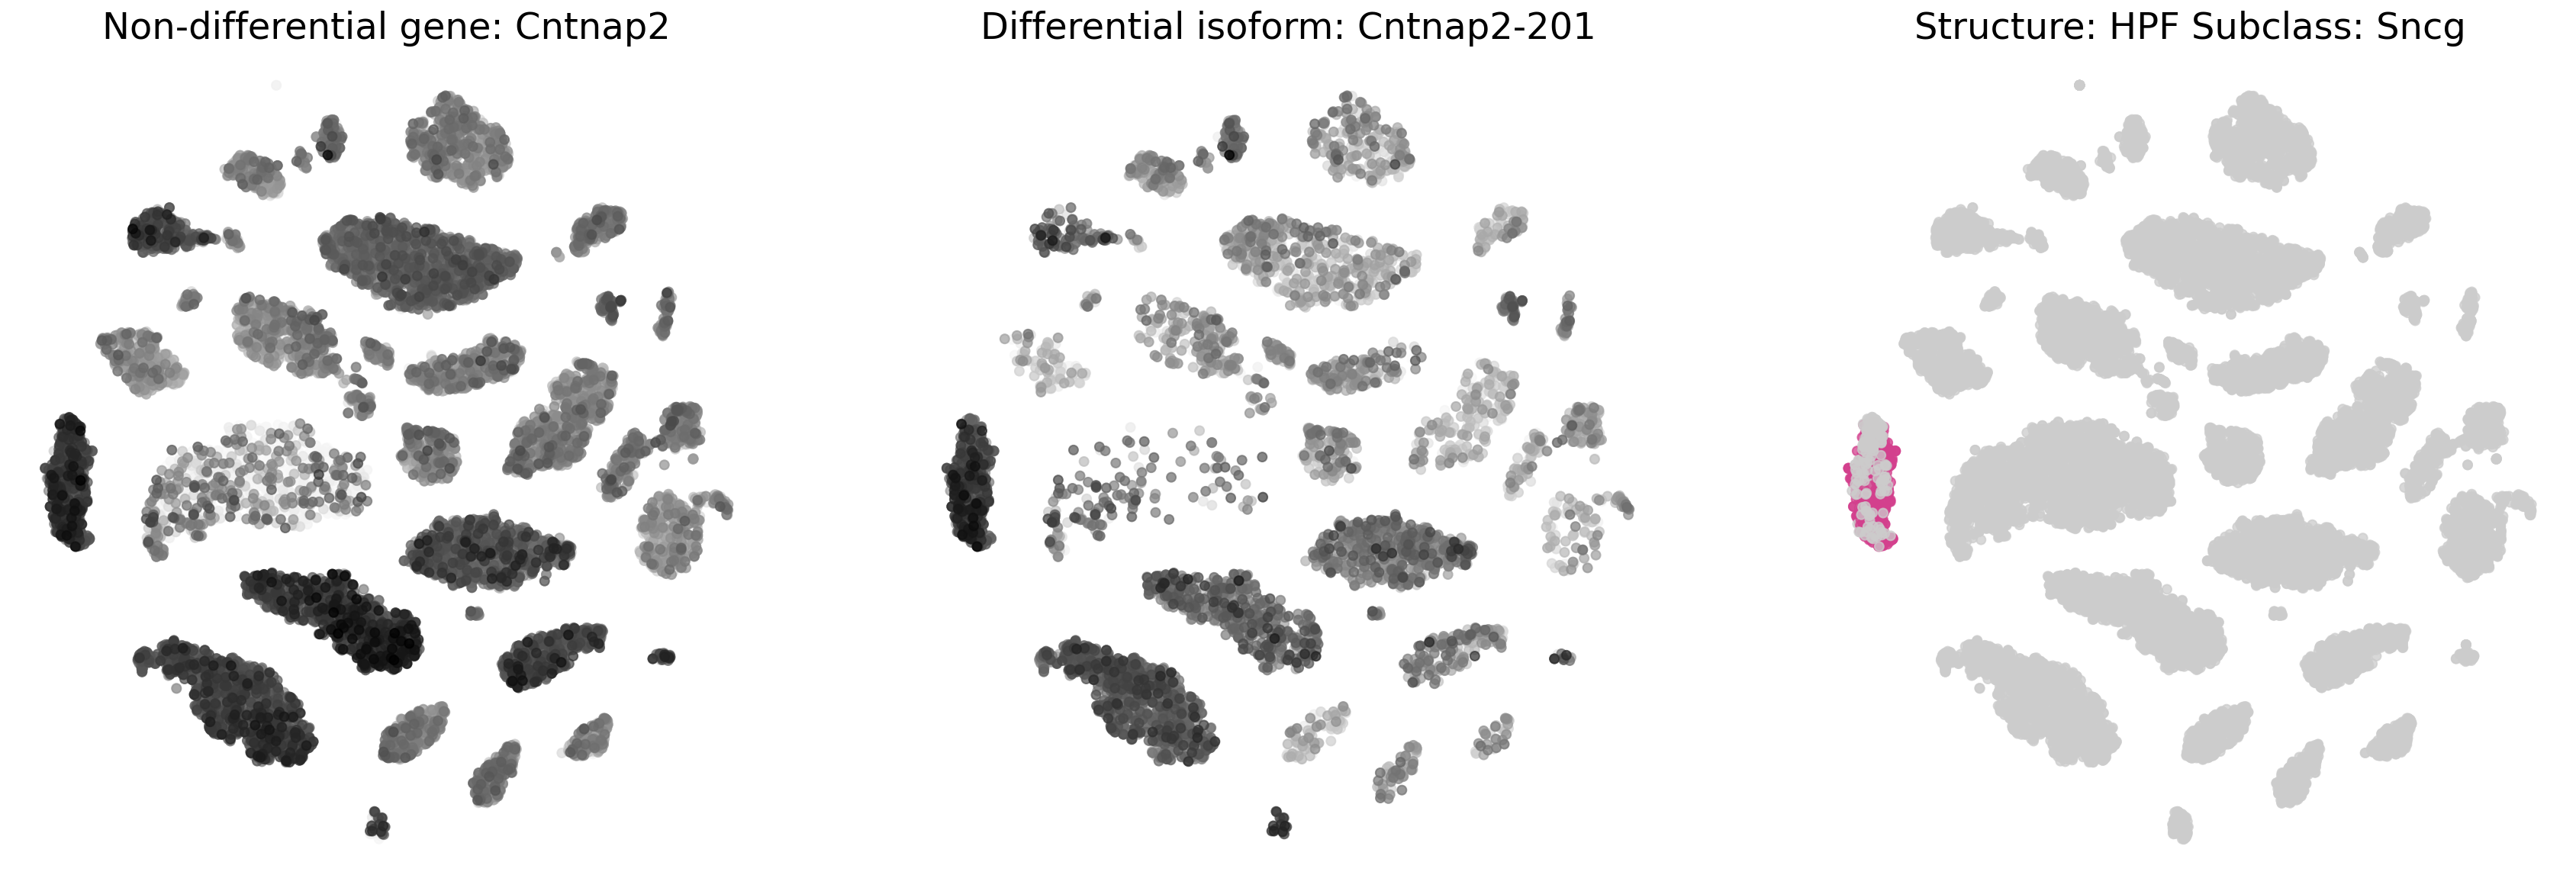

In [33]:
#this figure doesnt really make sense to use
complement_color = (0.8, 0.8, 0.8, 1.0)

fig, ax = plt.subplots(figsize=(30,10), ncols=3)

x = gene.obsm["X_nca_tsne"][:,0]
y = gene.obsm["X_nca_tsne"][:,1]
c = np.asarray(gene[:, gene.var.gene_name==specific_gene].layers["log1p"].todense()).reshape(-1)
argsort = np.argsort(c)
x = x[argsort]
y = y[argsort]
c = c[argsort]
cmap="Greys"
alpha = 0.75
ax[0].set_title("Non-differential gene: {}".format(specific_gene.split("_")[0]))

ax[0].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[0].set_axis_off()


x = gene.obsm["X_nca_tsne"][:,0]
y = gene.obsm["X_nca_tsne"][:,1]
c = np.asarray(isoform[:, isoform.var.transcript_name==specific_isoform].layers["log1p"].todense()).reshape(-1)
argsort = np.argsort(c)
x = x[argsort]
y = y[argsort]
c = c[argsort]
cmap="Greys"
alpha = 0.75
ax[1].set_title("Differential isoform: {}".format(specific_isoform.split("_")[0]))

ax[1].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[1].set_axis_off()

x = gene.obsm["X_nca_tsne"][:,0]
y = gene.obsm["X_nca_tsne"][:,1]
c = gene.obs["subclass_label"]==specific_cluster
c = gene.obs["subclass_label"].astype(str).map(subclass_cmap).tolist()
indices = np.where(np.logical_or(gene.obs["struct_label"]!=specific_cluster, gene.obs["subclass_label"]!=specific_subclass))[0]
replacements=[complement_color]*len(indices)
for (index, replacement) in zip(indices, replacements):
    c[index] = replacement
alpha=0.75
cmap="nipy_spectral_r"

ax[2].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[2].set_axis_off()
ax[2].set_title("Structure: {} Subclass: {}".format(specific_cluster, specific_subclass))
plt.savefig("../../figures/struct_subclass_DE_nca_all.png", bbox_inches='tight',dpi=300)
plt.show()

In [34]:
identified_isoforms = markers_isoform["name"].explode().astype(str)

In [35]:
identified_genes = identified_isoforms.apply(lambda x: x.split("-")[0:-1][0])

In [36]:
print("{} isoforms from {} genes identified.".format(identified_isoforms.shape[0], identified_genes.nunique()))

254 isoforms from 218 genes identified.


In [37]:
markers_isoform.to_csv("../../tables/unordered/struct_subclass_DE.csv")